# Investigate simulations with individual soil column per pft  

Inlcuding regridding

(c) Inne Vanderkelen - October 2023

## 1. Settings

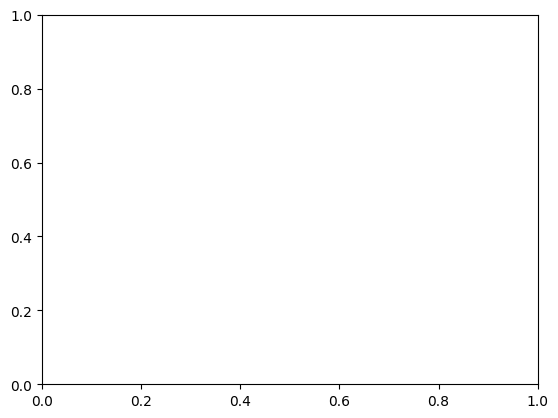

In [1]:
# laod modules 
import xarray as xr
import matplotlib.pyplot as plt
import os
import regionmask 
import pandas as pd

# import own utils module
from iv_utils_daint import *
from ctsm_py.utils import * #info on ctsm utils: https://github.com/NCAR/ctsm_python_gallery 

# do plotting settings
set_plot_param()

# ignore all runtime warnings
warnings.filterwarnings('ignore')

In [2]:
# directory settings

# set directories
outdir = '/scratch/snx3000/ivanderk/'

# Define directory where processing is done 
procdir =  outdir + 'processing_4p1000/' 

# go to processing directory 
os.chdir(procdir)

In [3]:
# case settings

# define scenario
scenario = '4p1000'

# case settings
case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup'
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup'


case   = case_ctl
block  = 'lnd' 
stream = 'h1' 

# List of variables to import from file(s) in $indir matching $pattern.
variables = ['H2OSOI',"TOTSOILLIQ","TOTSOILICE", "QINFL" , "QOVER", "QDRAI", 'EFLX_LH_TOT',  "watsat","QROOTSINK" ,"QVEGE", "QVEGT","QSOIL",
             "watfc", "EFF_POROSITY", ] #"SOILPSI", "FPSN","QHR","SMP","GSSHA","GSSUN"

# discard 2004 until 2008 as spin up years
start_year, end_year = 1995, 2014 

time_slice = slice(str(start_year)+"-01-01", str(end_year)+"-12-01")

In [4]:
## settings for plotting
ds_ctl =  load_case_ctl(['H2OSOI'])

# get mask and region ids
exclude_ids = np.array([0,1,2,16,28,29,30,31])
mask_regions = regionmask.defined_regions.ar6.land.mask(ds_ctl['H2OSOI'])

region_ids = np.arange(0,44)
region_ids = np.delete(region_ids, exclude_ids)

regions_sand_clay = [6, 7, 10, 11, 12, 14, 19, 21, 22, 23, 24, 26, 37, 38, 39, 41]

plotting_depth = 2 # m 8
figsize = (17,38)

In [5]:
# get pfts modelled - bare soil, grassland and crop pfts
pft_list_crops = [15,16]
pft_list_grassland = [100] # [0,12,13,14]

### Load auxiliary data (soil levels, input dataset, wilting point etc) 

In [6]:
# info on soil levels
# manually get soil level info from CLM
levsoi_thickness, levsoi_depth, levgrnd_thickness , levgrnd_depth = get_soildepths()

# get info on soil levels
levsoi = ds_ctl['levsoi'].values
levgrnd = ds_ctl['levgrnd'].values # all soil layers (deepest 5 layers are for thermodynamical calculations)

In [7]:
# input data
# define variables to load from input dataset
input_variables = ['ORGANIC','PFTDATA_MASK','PCT_SAND','PCT_CLAY']

# load inputdata
ds_input, ds_input_scen, landmask = load_inputdata(scenario, input_variables, case_ctl)

In [8]:
# get masks for sandy and clay soils

# define tresholds for pct sand and pct clay
pct_sand_threshold_min = 50
pct_sand_threshold_max = 85
pct_clay_threshold = 40
da_sand_mask, da_clay_mask = get_texture_masks(pct_sand_threshold_max,pct_sand_threshold_min,  pct_clay_threshold, ds_input, levsoi_thickness)



In [9]:
# wilting point
# load precalculated wilting point datasets
da_wilting_h2osoi, da_wilting_h2osoi_scen = load_wilting_h2osoi(scenario) 

## Look at maps

In [10]:
variables_toplot = ["TOTSOILLIQ", "QINFL" , "QOVER", "QDRAI",'EFLX_LH_TOT', "QVEGE", "QVEGT","QSOIL"]

In [11]:
# difference 

d_vlims = { "QDRAI"        : [-5e-3,5e-3], 
           "QINFL"         : [-5e-3,5e-3],
           "QOVER"         : [-5e-3,5e-3],
           "TOTSOILLIQ"    : [-5e-3,5e-3],
           "EFLX_LH_TOT"   : [-5e-3,5e-3],
           "QVEGT"         : [-5e-3,5e-3], 
           "QVEGE"         : [-5e-3,5e-3], 
           "QSOIL"         : [-5e-3,5e-3],
           "SOILWATER_10CM": [-4,4]}

In [12]:

pft_int = pft_list_grassland[0]

for i, variable in enumerate(variables_toplot): 
   
    da_pft_ctl = load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable)

    da_pft_scen = load_da_gridded_pft(variable, pft_int, case_scen).rename(variable)
    
    da_pft_ctl_conv = conv_hydrol_var(da_pft_ctl.to_dataset(), [variable])[variable]
    da_pft_ctl_conv.attrs['long_name'] = da_pft_ctl.long_name

    da_pft_scen_conv = conv_hydrol_var(da_pft_scen.to_dataset(),[variable])[variable]
    da_pft_scen_conv.attrs['long_name'] = da_pft_scen.long_name

    
    da_delta = da_pft_scen_conv - da_pft_ctl_conv
    calc_plot_delta_da(da_delta, da_pft_ctl_conv, variable, d_vlims)
    
    

AttributeError: 'DataArray' object has no attribute 'units'

In [11]:
d_vlims = { "QDRAI"         : [-1e-7,1e-7], 
           "QINFL"         : [-1e-5,1e-5],
           "QOVER"         : [-1e-7,1e-7],
           "TOTSOILLIQ"    : [-20,20],
           "TOTSOILICE"    :  [-20,20], 
           "SOILWATER_10CM": [-4,4],
           "TWS"           : [-8,8],
           "ZWT"           : [-0.005,0.005], 
           "QINFL"         : [-1e-5,1e-5],
           "EFLX_LH_TOT"         : [-0.5,0.5],
           "SOILLIQ"         : [-0.5,0.5],
           "SOILICE"         : [-0.5,0.5],
           "QVEGT"         : [-1e-7,1e-7], 
           "QVEGE"         : [-1e-8,1e-8], 
           "QSOIL"         : [-1e-7,1e-7], 
           "watfc"         : [-0.0002,0.0002], 
           "watsat"        : [-0.0002,0.0002], 
           "QHR"           : [-2e-7,2e-7], 
           'SMP'           : [-1000,1000],
           'SOILPSI'       : [-0.01,0.01]}


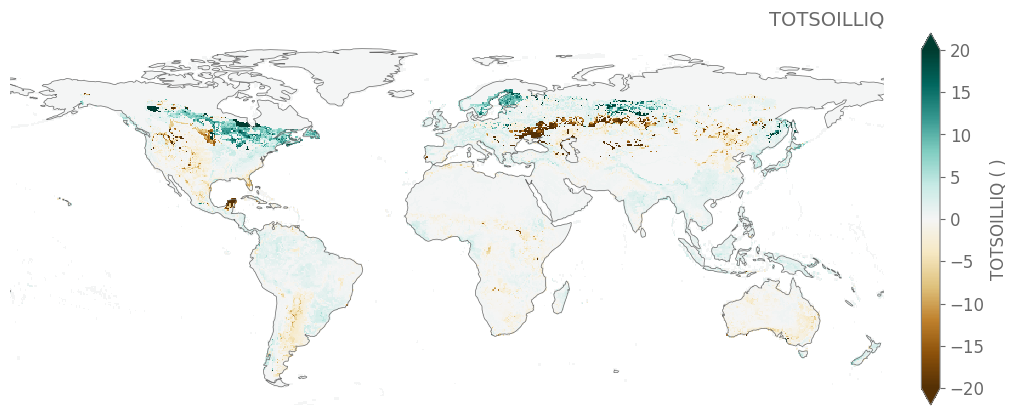

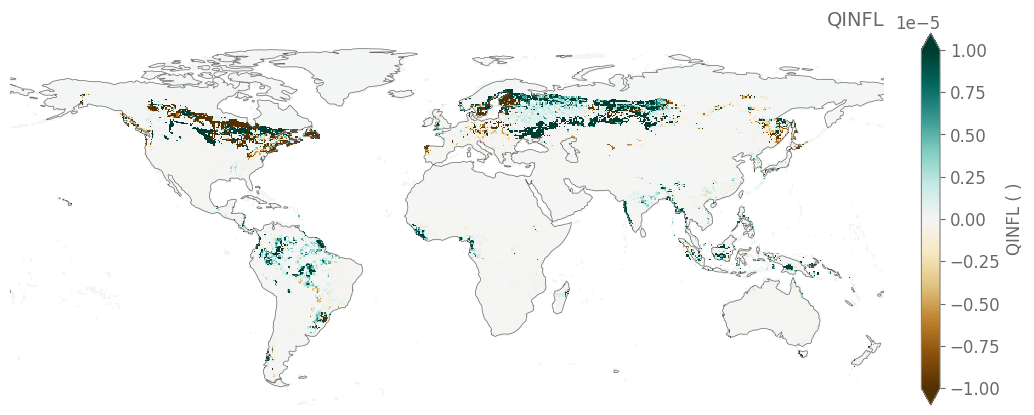

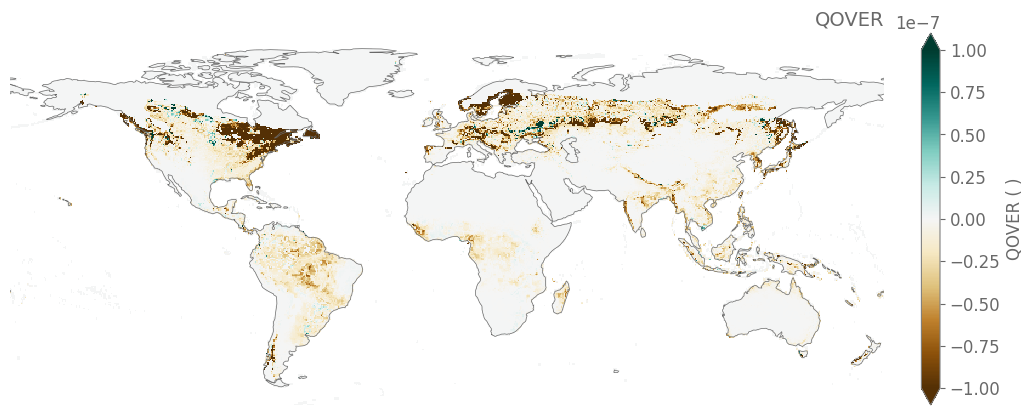

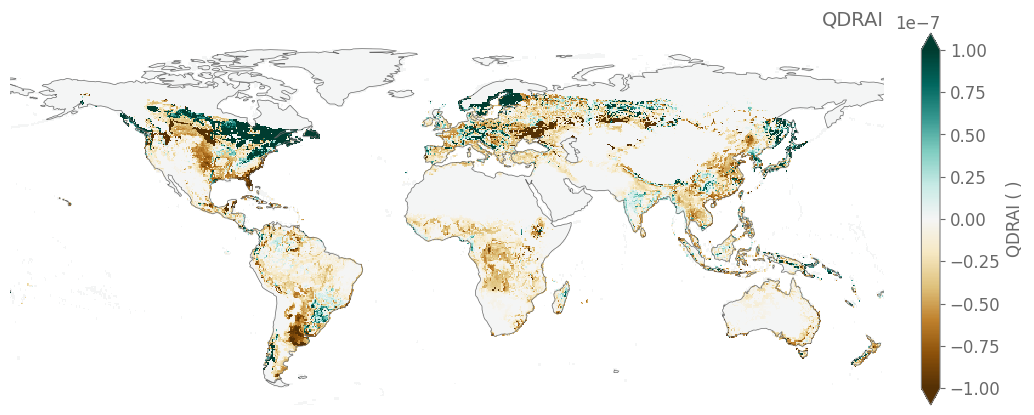

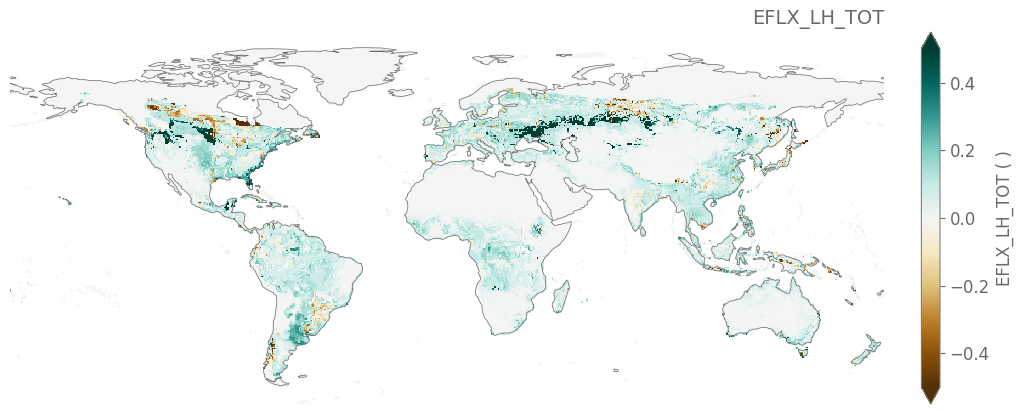

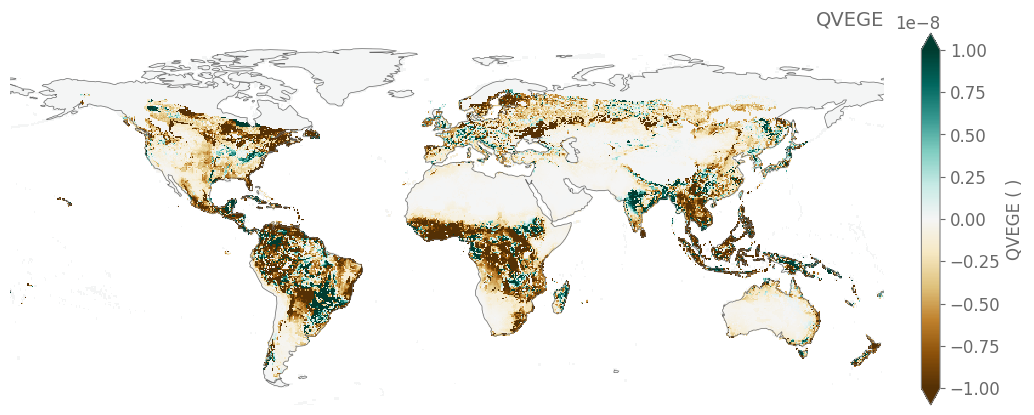

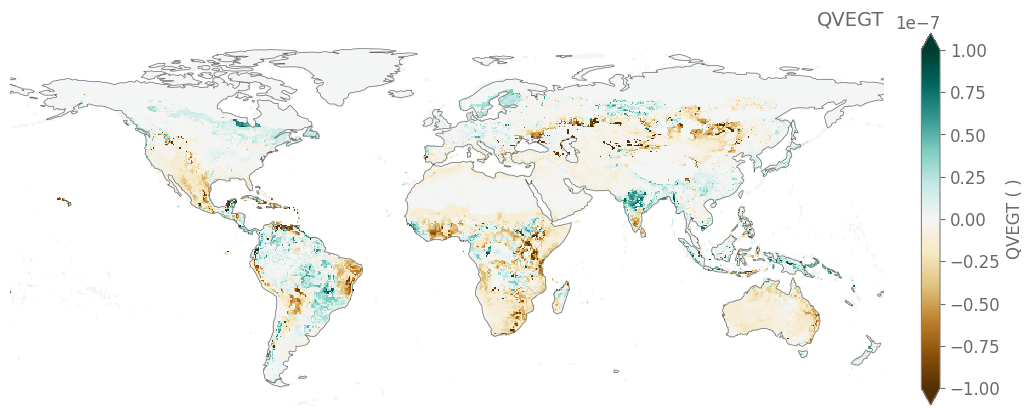

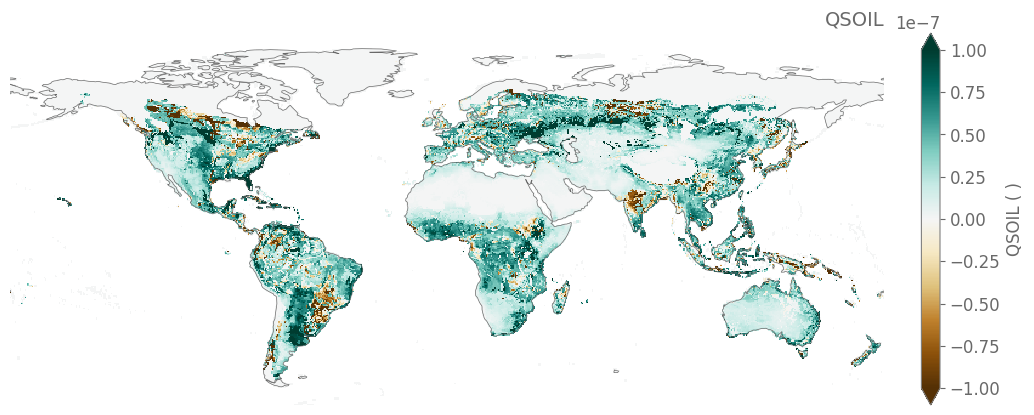

In [18]:

pft_int = pft_list_grassland[0]

for i, variable in enumerate(variables_toplot): 
   
    da_pft_ctl = load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable)

    da_pft_scen = load_da_gridded_pft(variable, pft_int, case_scen).rename(variable)

    da_delta = da_pft_scen - da_pft_ctl
    
    da_delta.attrs['units'] = ' '
    da_delta.attrs['long_name'] = da_delta.name
    da_pft_ctl.attrs['units'] = ' '
    da_pft_ctl.attrs['long_name'] = da_pft_ctl.name    
    
    calc_plot_delta_da(da_delta, da_pft_ctl, variable, d_vlims)
    
    
    


### RELATIVE maps

In [34]:
d_vlims = {"QDRAI"         : [-5,5], 
           "QINFL"         :  [-5,5], 
           "QOVER"         :  [-1,1], 
           "QRUNOFF"         : [-1e-7,1e-7],
           "TOTSOILLIQ"    :  [-1,1], 
           "TOTSOILICE"    :  [-10,10], 
           "SOILWATER_10CM":  [-5,5], 
           "TWS"           :  [-1,1], 
           "ZWT"           :  [-1,1], 
           "FH2OSFC"      :  [-5,5], 
           "EFLX_LH_TOT"         : [-1,1],
            "H2OSOI"         : [-0.1,0.1],
            "SOILLIQ"         : [-1,1],
            "SOILICE"         : [-20,20],
           "watfc"         : [-0.01,0.01], 
           "watsat"        : [-0.01,0.01],       
           'SOILPSI'       : [-1,1],
           'SMP'           : [-2,2],
          "QHR" : [-50,50]}


TOTSOILLIQ
QINFL
QOVER
QDRAI
EFLX_LH_TOT
QVEGE
QVEGE not in limits
QVEGT
QVEGT not in limits
QSOIL
QSOIL not in limits


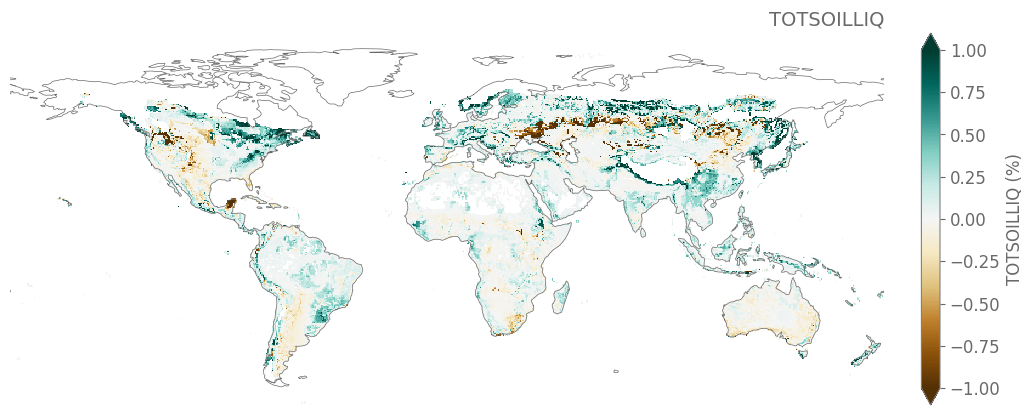

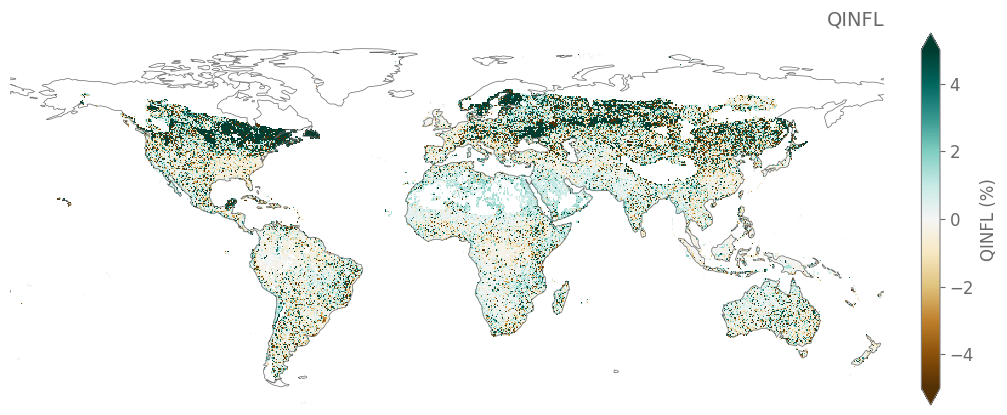

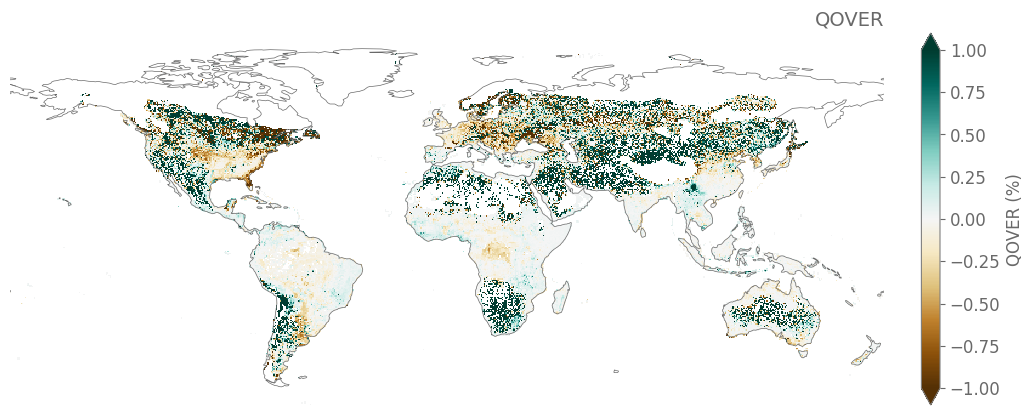

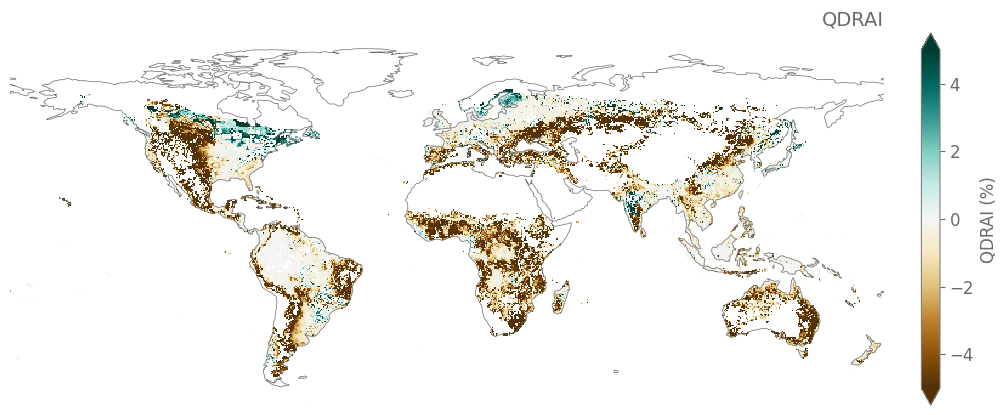

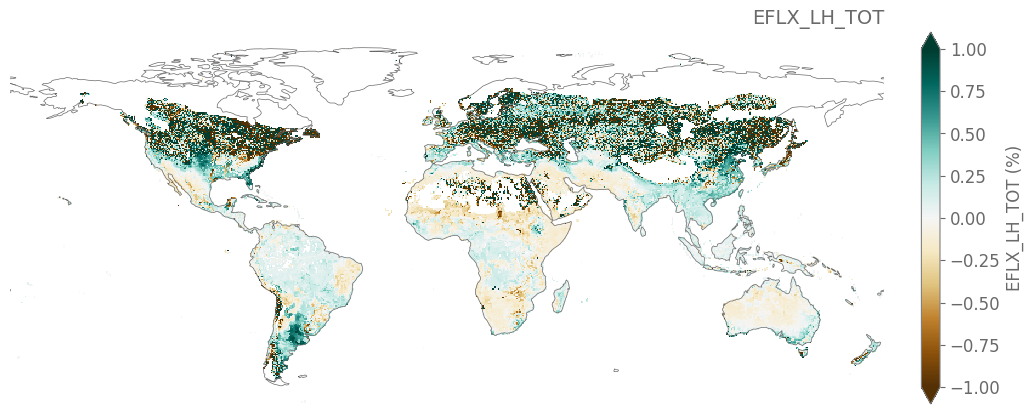

In [35]:

pft_int = pft_list_grassland[0]

for i, variable in enumerate(variables_toplot): 
    print(variable)
   
    da_pft_ctl = load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable)

    da_pft_scen = load_da_gridded_pft(variable, pft_int, case_scen).rename(variable)

    da_delta = da_pft_scen - da_pft_ctl
    
    da_delta.attrs['units'] = 'mm/s'
    da_delta.attrs['long_name'] = da_delta.name
    da_pft_ctl.attrs['units'] = 'mm/s'
    da_pft_ctl.attrs['long_name'] = da_pft_ctl.name    
    
    calc_plot_delta_rel_da(da_delta, da_pft_ctl, variable, d_vlims)
    
